# Show behavior predictions for specific neural models

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot, plot_b

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

ALPHA = 10

FPS = 30.03

In [2]:
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

# Population MA model predicting motion

In [3]:
TARG_BHV = 'MTN'
TWDW = 1
TARG = f'{TARG_BHV}_MN_{TWDW}'

LOAD_DIR = 'neur_basic'

NRL_MDLS = ['lnma_tweaked', 'ma']
COLORS = ['m', 'k']

FLOADS = [
    f'data/simple/mlv/{LOAD_DIR}/baker_{nrl_mdl}_{"_".join(STRAINS).lower()}_{TARG_BHV.lower()}_ridge_alpha_{ALPHA}.npy'
    for nrl_mdl in NRL_MDLS
]

In [4]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')

In [5]:
# split big df into dfs for individual trials
ntr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(ntr)]

tr_lens = np.array([len(df_tr) for df_tr in dfs_tr])
tr_lens_cum = cc([[0], np.cumsum(tr_lens)])

n_t_total = np.sum(tr_lens)
assert n_t_total == tr_lens_cum[-1]
df_behav = None

### Single trial

In [6]:
TWDW = 1
TARG = f'{TARG_BHV}_MN_{TWDW}'

ISPLIT = 0
TEST_ITRS = [13]  # 0: 1, 3, 13, 15; 1: 2, 16; 2: 5, 13
ITR_ORIG = ISTRAIN[67]  # look up in 0

In [7]:
# get song
df_tr = dfs_tr[ITR_ORIG]
song = np.zeros(len(df_tr), dtype=int)
song[np.array(df_tr['S']) == 1] = 1
song[np.array(df_tr['P']) == 1] = 2
song[np.array(df_tr['F']) == 1] = 2

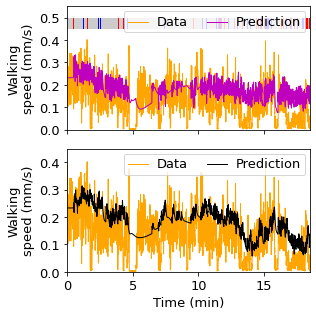

In [8]:
Y_LIMS = [(0, 0.55), (0, 0.45)]

fig, axs = plt.subplots(len(NRL_MDLS), 1, figsize=(4.5, 4.5), sharex=True, tight_layout=True)  #, squeeze=False)[:, 0]

for ax, nrl_mdl, color, fload, y_lim in zip(axs, NRL_MDLS, COLORS, FLOADS, Y_LIMS):

    data = np.load(fload, allow_pickle=True)[0]

    for itr in TEST_ITRS:
        y = data['ys_test'][TARG][ISPLIT][itr]
        y_hat = data['y_hats_test'][TARG][ISPLIT][itr]
        t = np.arange(len(y))/FPS

        ax.plot(t/60, y, c='orange', lw=1)
        ax.plot(t/60, y_hat, c=color, lw=1)
        
    if ax is axs[0]:
        plot_b(ax, t/60, song, extent=[0, t[-1]/60, .45, .5], c=[(.8, .8, .8), 'b', 'r'])

    ax.legend(['Data', 'Prediction'], ncol=2)
    set_plot(ax, x_lim=(0, t[-1]/60), y_lim=y_lim, y_label=f'Walking\nspeed (mm/s)', font_size=13)
set_plot(axs[1], x_ticks=[0, 5, 10, 15], x_label='Time (min)', font_size=13)
    
fig.savefig('ms/fig_1f.svg')

### Multiple trials

In [9]:
TWDW = 1
TARG = f'{TARG_BHV}_MN_{TWDW}'

ISPLIT = 0
TEST_ITRS = [13, 15, 3]  # 0: 1, 3, 13, 15; 1: 2, 16; 2: 5, 13

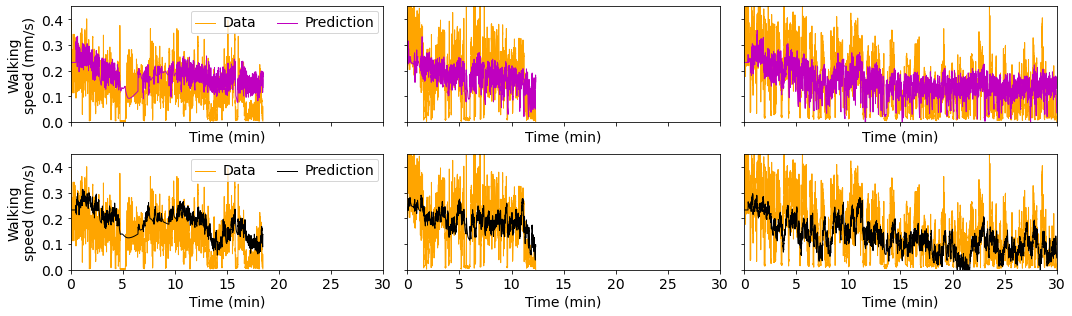

In [10]:
Y_LIMS = [(0, 0.55), (0, 0.45)]

fig, axs_all = plt.subplots(len(NRL_MDLS), len(TEST_ITRS), figsize=(15, 4.5), sharex=True, sharey=True, tight_layout=True)  #, squeeze=False)[:, 0]

for axs, nrl_mdl, color, fload, y_lim in zip(axs_all, NRL_MDLS, COLORS, FLOADS, Y_LIMS):

    data = np.load(fload, allow_pickle=True)[0]

    for ax, itr in zip(axs, TEST_ITRS):
        y = data['ys_test'][TARG][ISPLIT][itr]
        y_hat = data['y_hats_test'][TARG][ISPLIT][itr]
        t = np.arange(len(y))/FPS

        ax.plot(t/60, y, c='orange', lw=1)
        ax.plot(t/60, y_hat, c=color, lw=1)

    # if ax is axs[0]:
    #     plot_b(ax, t/60, song, extent=[0, t[-1]/60, .45, .5], c=[(.9, .9, .9), 'b', 'r'])

    axs[0].legend(['Data', 'Prediction'], ncol=2)
    set_plot(axs[0], x_lim=(0, t[-1]/60), y_lim=y_lim, y_label=f'Walking\nspeed (mm/s)', font_size=14)
    for ax in axs:
        set_plot(ax, x_ticks=[0, 5, 10, 15, 20, 25, 30], x_label='Time (min)', font_size=14)
        
fig.savefig('supp/7_xpl_ln_ma_fits_1s_fmtn.svg')

## Multiple trials (1-min averaging)

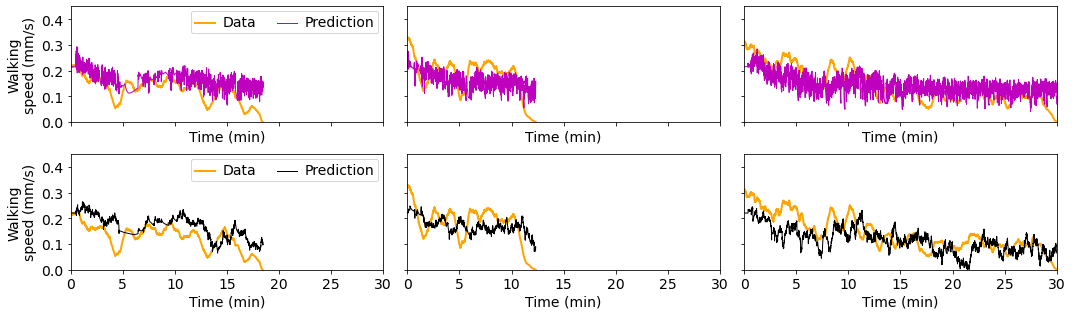

In [11]:
TWDW = 60
TARG = f'{TARG_BHV}_MN_{TWDW}'

Y_LIMS = [(0, 0.55), (0, 0.45)]

fig, axs_all = plt.subplots(len(NRL_MDLS), len(TEST_ITRS), figsize=(15, 4.5), sharex=True, sharey=True, tight_layout=True)  #, squeeze=False)[:, 0]

for axs, nrl_mdl, color, fload, y_lim in zip(axs_all, NRL_MDLS, COLORS, FLOADS, Y_LIMS):

    data = np.load(fload, allow_pickle=True)[0]

    for ax, itr in zip(axs, TEST_ITRS):
        y = data['ys_test'][TARG][ISPLIT][itr]
        y_hat = data['y_hats_test'][TARG][ISPLIT][itr]
        t = np.arange(len(y))/FPS

        ax.plot(t/60, y, c='orange', lw=2)
        ax.plot(t/60, y_hat, c=color, lw=1)

    # if ax is axs[0]:
    #     plot_b(ax, t/60, song, extent=[0, t[-1]/60, .45, .5], c=[(.9, .9, .9), 'b', 'r'])

    axs[0].legend(['Data', 'Prediction'], ncol=2)
    set_plot(axs[0], x_lim=(0, t[-1]/60), y_lim=y_lim, y_label=f'Walking\nspeed (mm/s)', font_size=14)
    for ax in axs:
        set_plot(ax, x_ticks=[0, 5, 10, 15, 20, 25, 30], x_label='Time (min)', font_size=14)
        
fig.savefig('supp/7_xpl_ln_ma_fits_60s_fmtn.svg')